# Разработка A/B-тестирования и анализ результатов

**Цель работы** - проведение A/B-теста, который позволит проверить гипотезу об увеличении вовлеченности пользователей в приложение с новым контентом, и анализ полученных результатов.

## Описание данных

В работе будут использованы данные из трех таблиц:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. 

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. 

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. 


У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


### Работа с историческими данными (EDA)

#### Загрузка исторических данных

Считаем и сохраним в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведим на экран первые пять строк полученного датафрейма.

In [1]:
# Импортируем необходимые для анализа данных библиотеки и модули:
import pandas as pd

!pip install matplotlib_venn -q
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.simplefilter(action='ignore')

In [2]:
# Проверим существующие версии библиотек и при необходимости заменим на более новые:
import pandas; print(pandas.__version__)
import matplotlib; print(matplotlib.__version__)
import seaborn; print(seaborn.__version__)

1.3.4
3.4.3
0.11.2


In [3]:
!pip install pandas==1.3.4

In [4]:
!pip install matplotlib==3.4.3


In [5]:
!pip install seaborn==0.11.2

In [6]:
# Преобразуем датасет 'sessions_project_history.csv' в датафрейм 'sessions_history' и выведем первые строки:
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [7]:
# Выгрузим необходимую информацию для ознакомления с полученным датафреймом:
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


#### Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий и, если таких несколько, выберем любого из них.

- Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [8]:
# Сгруппируем уникальных пользователей по количеству уникальных сессий:
user_group = sessions_history.groupby('user_id')['session_id'].nunique().sort_values(ascending=False).reset_index()
print(user_group)

                 user_id  session_id
0       10E0DEFC1ABDBBE0          10
1       6A73CB5566BB494D          10
2       8A60431A825D035B           9
3       D11541BAC141FB94           9
4       5BCFE7C4DCC148E9           9
...                  ...         ...
134034  1DF13BB1953B3497           1
134035  628502A3CE7E0A3C           1
134036  1DEEF40DEFBD0C65           1
134037  AC08479B7472C628           1
134038  8A0882B6715D9EE5           1

[134039 rows x 2 columns]


In [9]:
# Выведем на экран все данные из таблицы 'sessions_history' для пользователя с идентификатором '10E0DEFC1ABDBBE0',
# у которого максимальное число сессий:
sessions_history_max = sessions_history[sessions_history['user_id']=='10E0DEFC1ABDBBE0']
display(sessions_history_max)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### Анализ числа регистраций
Изучим первую важную метрику продукта — число регистраций пользователей в приложении. Используя исторические данные, визуализируем, как менялось число регистраций пользователей в приложении за время его существования. Для этого:

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты будем считать, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням и  отобразим их на одном графике.

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

In [10]:
# Сгруппируем общее количество пользователей и число зарегистрированных пользователей по дням:
days_group = sessions_history.groupby('session_date').agg(total_users=('user_id', 'nunique'), 
                                                reg_users=('registration_flag', 'sum')).reset_index()
print(days_group)

   session_date  total_users  reg_users
0    2025-08-11         3919        169
1    2025-08-12         6056        336
2    2025-08-13         8489        464
3    2025-08-14        10321        625
4    2025-08-15        14065        840
5    2025-08-16        12205        916
6    2025-08-17        11200        833
7    2025-08-18        10839        860
8    2025-08-19        12118        831
9    2025-08-20        13514       1008
10   2025-08-21        15051       1063
11   2025-08-22        17563       1251
12   2025-08-23        16082       1253
13   2025-08-24        13683       1181
14   2025-08-25        13635       1060
15   2025-08-26        13289       1050
16   2025-08-27        14766       1076
17   2025-08-28        15388       1175
18   2025-08-29        16873       1174
19   2025-08-30        14891       1165
20   2025-08-31        13266       1105
21   2025-09-01        12685       1028
22   2025-09-02        12672       1039
23   2025-09-03        12777       1035


**На основе полученных данных построим график, отражающий динамику всех пользователей и зарегистрированных по дням.**

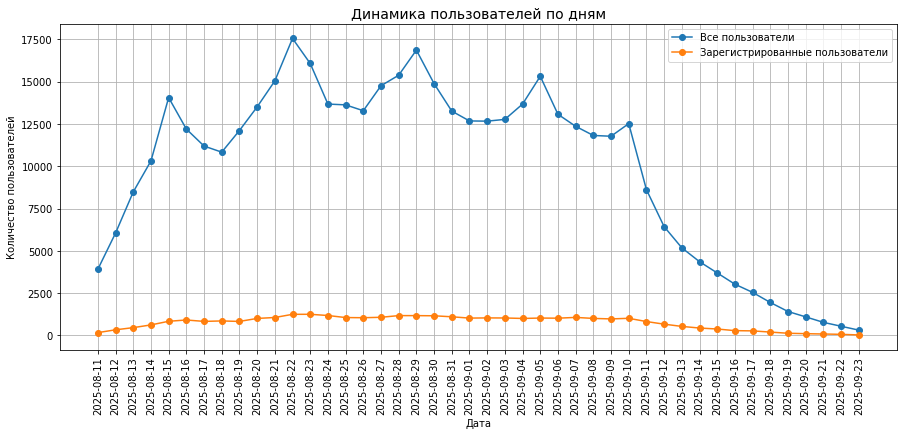

In [11]:
# Зададим параметры общего графика и построим линейные графики динамики пользователей:
plt.figure(figsize=(15, 6))
plt.plot(days_group['session_date'], days_group['total_users'], label='Все пользователи', marker='o')
plt.plot(days_group['session_date'], days_group['reg_users'], label='Зарегистрированные пользователи', marker='o')
plt.title('Динамика пользователей по дням', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

***На графике видно, что ежедневное количество регистраций пользователей за период с 16.08.2025 по 10.09.2025, практически, одинаково. А начиная с 11.09.2025, число регистраций уменьшается и приходит к нулю. Также, отметим, что интерес к приложению общего числа пользователей отмечается в период с 15.08.2025 по 10.09.2025, а затем резко уменьшается, начиная с 10.09.2025, и, также, к концу анализируемого периода сводится к нулю. Возможно, в этот период проводились какие-либо акции (и т.п.), что привлекло прирост пользователей.***

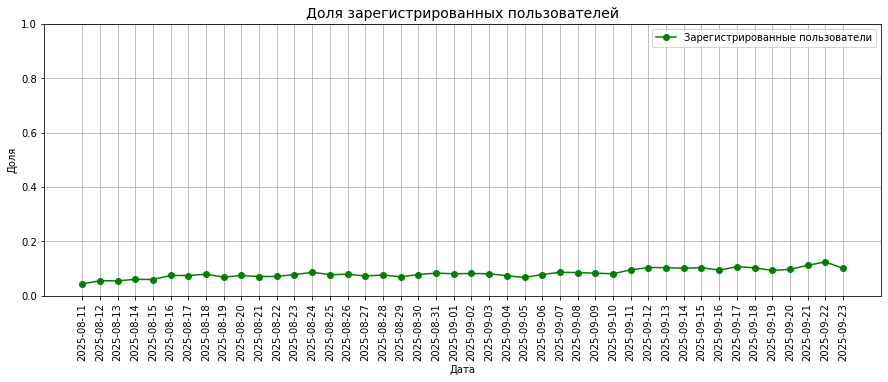

In [12]:
# Сохраним в колонке 'days_group['reg_total']' долю зарегистрированных пользователей от общего их числа: 
days_group['reg_total'] = days_group['reg_users'] / days_group['total_users']

# Представим визуально долю зарегистрированных пользователей по дням:
plt.figure(figsize=(15, 5))
plt.plot(days_group['session_date'], days_group['reg_total'], label='Зарегистрированные пользователи', marker='o', c='green')
plt.title('Доля зарегистрированных пользователей', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Доля')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

***На графике видно, что доля ежедневных регистраций составляет, примерно, 10% от общего числа пользователей.***

#### Анализ числа просмотренных страниц
Перейдем к следующей важной метрике продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц.

- Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

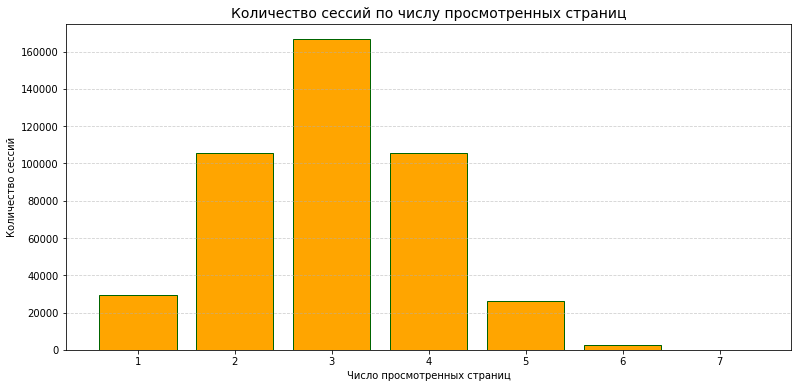

In [13]:
# Сгруппируем число уникальных сессий по количеству просмотренных страниц:
page_group = sessions_history.groupby('page_counter')['session_id'].nunique().reset_index()
page_group.columns = ['page_counter', 'sessions_count']

# Зададим параметры визуализации и построим столбчатую диаграмму:
plt.figure(figsize=(13, 6))
plt.bar(page_group['page_counter'], page_group['sessions_count'], color='orange', edgecolor='darkgreen')

plt.title('Количество сессий по числу просмотренных страниц', fontsize=14)
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(page_group['page_counter'])
plt.show()

***Видно, что максимальное число сессий приходится на пользователей, которые просматривают при посещении приложения 3 страницы.***

#### Доля пользователей, просмотревших более четырёх страниц
Рассмотрим показатель числа сессий, в рамках которых пользователь просмотрел 4 и более страниц. Этот показатель является важной прокси-метрикой для продукта, так как говорит об удовлетворённости пользователей контентом и алгоритмами рекомендаций.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

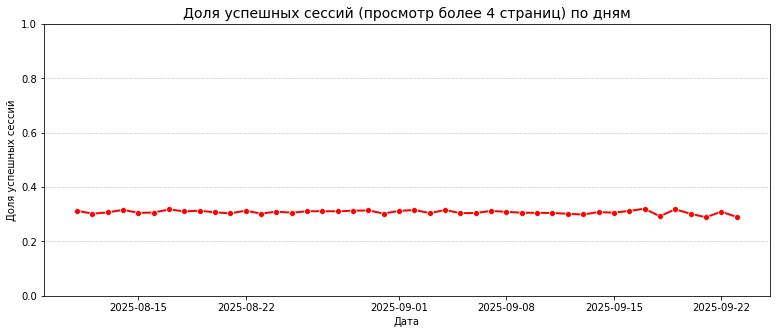

In [14]:
# Преобразуем столбец 'session_date' в формат datetime:
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])

# Создадим функцию is_good_session, которая будем возвращать значения "0" или "1" 
# в зависимости от кол-ва просмотренных страниц:
def is_good_session(x):
    return 1 if x >= 4 else 0

# Добавим столбец 'good_session':
sessions_history['good_session'] = sessions_history['page_counter'].apply(is_good_session)

# Сгруппируем по дням (по датам) и посчитаем долю успешных сессий по значениям "1" столбца 'good_session' 
# с помощью метода mean():
daily_group = sessions_history.groupby(sessions_history['session_date'].dt.date)['good_session'].mean().reset_index()    
daily_group.columns = ['session_date', 'good_session_ratio']

# Построим линейный график для отображения доли успешных сессий:
plt.figure(figsize=(13, 5))
sns.lineplot(data=daily_group, x='session_date', y='good_session_ratio', marker='o', color='red', linewidth=2)

plt.title('Доля успешных сессий (просмотр более 4 страниц) по дням', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.ylim(0, 1)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=0)
plt.show()

***На графике можно отметить, что доля успешных сессий распределена равномерно по дням и колеблется в пределах 30% от общего числа сессий.***

###  Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулируем нулевую и альтернативную гипотезы.

- Определим целевую метрику.

- Рассчитаем необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитаем необходимую длительность проведения теста.

#### Формулировка нулевой и альтернативной гипотез


**Сформулируем нулевую и альтернативную гипотезы:**

***Нулевая гипотеза*** *: новый контент не повлияет на вовлеченность пользователей в приложение (изменения целевой метрики - доля успешных сессий между группами А (без нового алгоритма) и В (с новым алгоритмом) - не последует).*


**H0: mu_a = mu_b**

***Альтернативная гипотеза*** *: новый контент увеличит вовлеченность пользователей в приложение (определяющая метрика тестовой группы В будут больше, чем в контрольной группе А).*


**H1: mu_a < mu_b**



#### Расчёт размера выборки
Рассчитаем необходимое для эксперимента количество пользователей.

Для этого в коде установим следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3% (в виде десятичной дроби). 

При расчёте размера выборки используем метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустим ячейку и изучим полученное значение.

In [15]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Зададим параметры:
alpha = 0.05 # Уровень значимости
beta = 0.2 # Ошибка второго рода, часто 1 - мощность
power = 0.8 # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект (3% от p)
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower:
power_analysis = NormalIndPower()

# Рассчитаем размер выборки:
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1, # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитаем длительность теста, разделив одно на другое.

- Рассчитаем среднее количество уникальных пользователей приложения в день.

- Определим длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлим в большую сторону.

In [16]:
from math import ceil

# Определим среднее количество пользователей приложения в день по историческим данным:
avg_daily_users = int(sessions_history.groupby('session_date')['user_id'].nunique().mean())

# Рассчитаем длительность теста в днях, как отношение размера выборки к среднему числу пользователей:
test_duration = ceil(2 * sample_size / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 9 дней


### Мониторинг А/В-теста

#### Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются. Для этого:

- Считаем и сохраним в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B. Построим удобную визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [17]:
# Сохраним в датафрейм 'sessions_test_part' датасет 'sessions_project_test_part.csv' и выведем первые его строки:
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [18]:
# Выведем информацию о датафрейме:
sessions_test_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            3130 non-null   object
 1   session_id         3130 non-null   object
 2   session_date       3130 non-null   object
 3   session_start_ts   3130 non-null   object
 4   install_date       3130 non-null   object
 5   session_number     3130 non-null   int64 
 6   registration_flag  3130 non-null   int64 
 7   page_counter       3130 non-null   int64 
 8   region             3130 non-null   object
 9   device             3130 non-null   object
 10  test_group         3130 non-null   object
dtypes: int64(3), object(8)
memory usage: 269.1+ KB


In [19]:
# Сохраним в переменной 'uniq_users' количество уникальных пользователей в группах А и В (за первый день теста):
uniq_users = sessions_test_part.groupby('test_group')['user_id'].nunique()
print(uniq_users)

test_group
A    1477
B    1466
Name: user_id, dtype: int64


In [20]:
# И выведем разницу в количестве пользователей между группами в относительном значении:
A = uniq_users['A']
B = uniq_users['B']

perc_diff = 100 * abs(A - B) / A
print(f'Процентная разница между группами А и В: {perc_diff:.2f}%')

Процентная разница между группами А и В: 0.74%


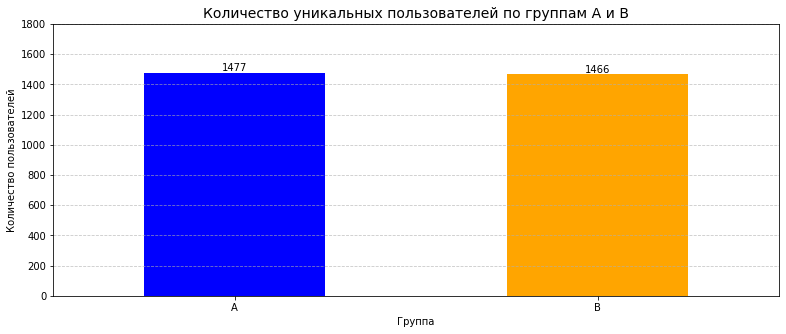

In [21]:
# Завизуализируем результат различия групп А и В по количеству пользователей:
plt.figure(figsize=(13, 5))

ax = uniq_users.plot(kind='bar', color=['blue', 'orange'])
ax.bar_label(ax.containers[0], label_type='edge')
plt.title('Количество уникальных пользователей по группам А и В', fontsize=14)
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=0)
plt.ylim(0, 1800)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, или убедимся в том, что таких нет.

In [22]:
# Выведем группы А и В в виде множеств, используя функцию set():
groupp_A = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'])
groupp_B = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'])

# Определим пересечение пользователей (одновременное присутствие пользователей в группе А и В):
dubl_users = groupp_A & groupp_B

# Результат:
if not dubl_users:
    print('Группы А и В полностью независимы - пересечений нет')
else:
    print(f'Обнаружено {len(dubl_users)} пересекающихся пользователей: {dubl_users}')


Группы А и В полностью независимы - пересечений нет


***Представим визуально результат пересечений с помощью диаграммы Венна***

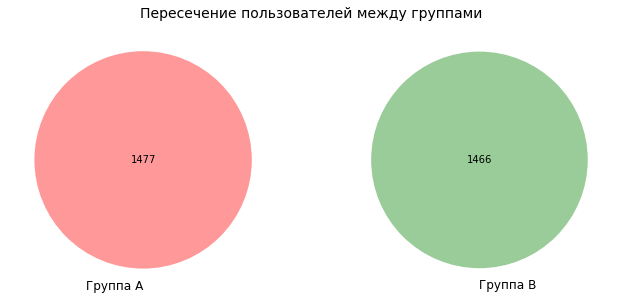

In [23]:
# Зададим параметры визуализации:
plt.figure(figsize=(12, 5))
venn2([groupp_A, groupp_B], ('Группа А', 'Группа В'))
plt.title('Пересечение пользователей между группами', fontsize=14)
plt.show()

***График подтверждает, что группы А и В независимы.***

#### Равномерность разделения пользователей по устройствам
Также убедимся в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

In [24]:
# Для понимания, выведем все имеющиеся уникальные типы устройств:
type_device = sessions_test_part['device'].unique()
print(type_device)

['Android' 'iPhone' 'PC' 'Mac']


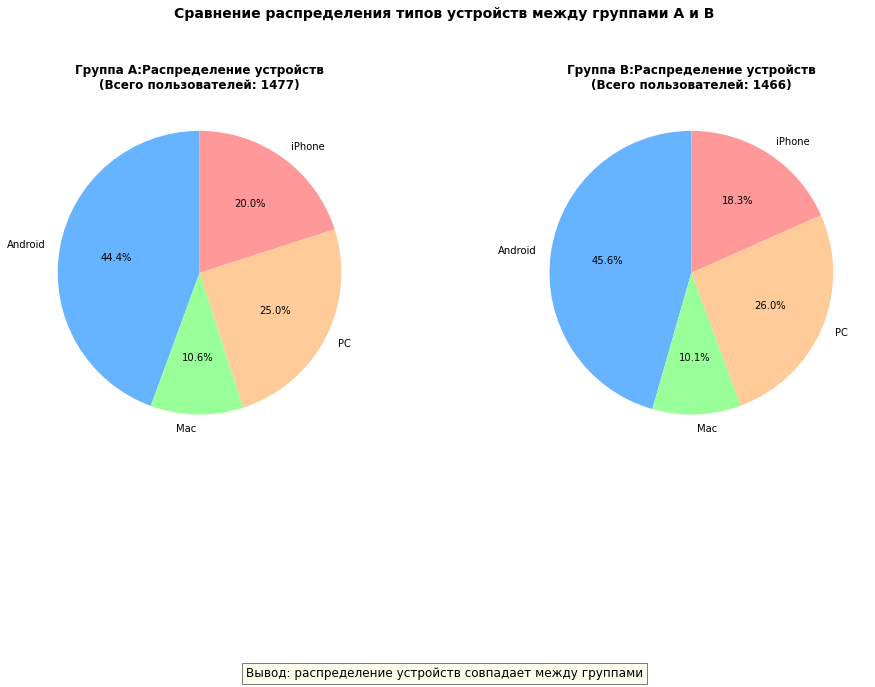

In [25]:
# Сохраним в переменную 'count_users' число уникальных пользователей, cгруппированных по группе и устройству:
dev_users = sessions_test_part.groupby(['test_group', 'device'])['user_id'].nunique().reset_index()

# Сгруппируем данные по группам А и В:
group_a = dev_users[dev_users['test_group'] == 'A']
group_b = dev_users[dev_users['test_group'] == 'B']

# Рассчитаем доли для каждой группы:
group_a['share'] = group_a['user_id'] / group_a['user_id'].sum() * 100
group_b['share'] = group_b['user_id'] / group_b['user_id'].sum() * 100

# Cоздадим график:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Построим график для группы А в виде круговой диаграммы:
ax1.pie(group_a['share'], labels=group_a['device'], 
       autopct='%.1f%%', colors=['#66b3ff', '#99ff99', '#ffcc99', '#ff9999'],
       startangle=90)
ax1.set_title('Группа А:Распределение устройств\n(Всего пользователей: {})'.format(group_a['user_id'].sum()), fontweight='bold')

# Также, построим круговую диаграмму для группы B:
ax2.pie(group_b['share'], labels=group_b['device'], 
       autopct='%.1f%%', colors=['#66b3ff', '#99ff99', '#ffcc99', '#ff9999'],
       startangle=90)
ax2.set_title('Группа B:Распределение устройств\n(Всего пользователей: {})'.format(group_b['user_id'].sum()), fontweight='bold')

# Сформируем общий заголовок:
plt.suptitle('Сравнение распределения типов устройств между группами А и В', y=1.05, fontsize=14, fontweight='bold')

# Добавим пояснение к графику:
fig.text(0.5, -0.5, 'Вывод: распределение устройств {} между группами'.format(
                     'совпадает' if np.allclose(group_a['share'], group_b['share'], atol=5)
                      else 'различается'), ha='center', fontsize=12, bbox=dict(facecolor='lightyellow', alpha=0.5))

plt.tight_layout()
plt.show()

#### Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

In [26]:
# Выведем все уникальные названия регионов:
type_device = sessions_test_part['region'].unique()
print(type_device)

['CIS' 'MENA' 'EU']


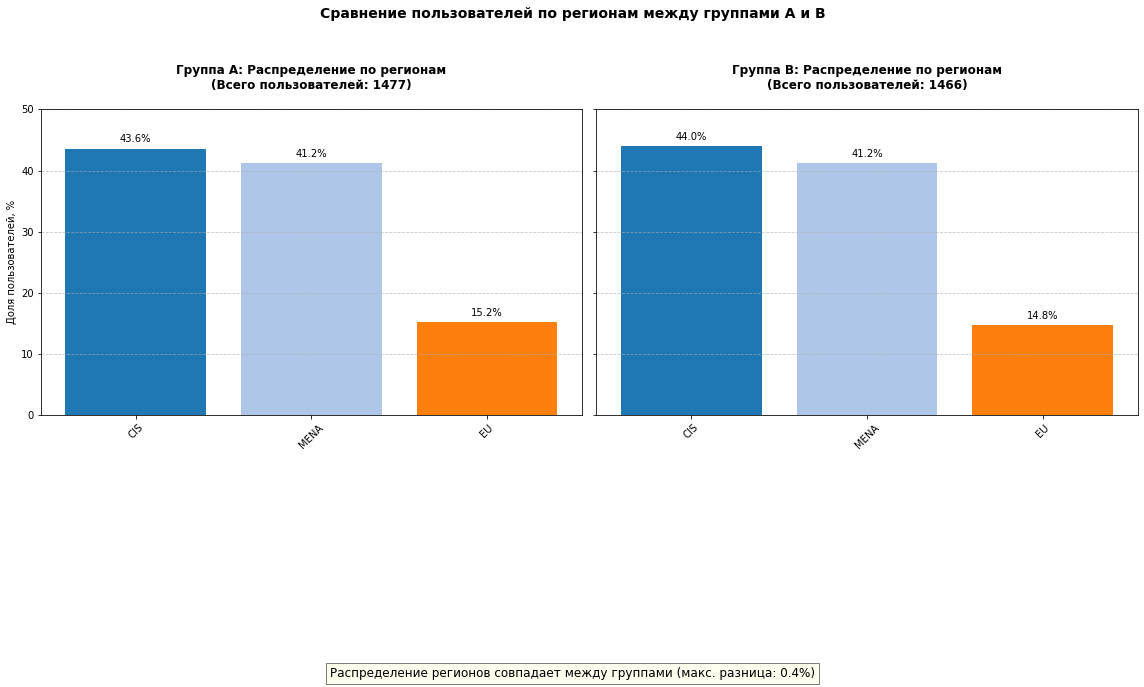

In [27]:
# Подсчитаем количество пользователей по регионам для каждой группы:
reg_users = sessions_test_part.groupby(['test_group', 'region'])['user_id'].nunique().unstack(fill_value=0)

# Рассчитаем доли каждого региона (в процентах):
reg_perc = reg_users.div(reg_users.sum(axis=1), axis=0) * 100

# Подготовим данные в относительных значениях по группам для визуализации:
group_a_perc = reg_perc.loc['A'].sort_values(ascending=False)
group_b_perc = reg_perc.loc['B'].sort_values(ascending=False)

# Зададим параметры графиков:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Построим график для группы А в виде столбчатой диаграммы:
colors = plt.cm.tab20.colors
ax1.bar(group_a_perc.index, group_a_perc.values, color=colors[:len(group_a_perc)]) 
ax1.set_title('Группа А: Распределение по регионам\n(Всего пользователей: {})'.format(reg_users.loc['A'].sum()),
               fontweight='bold', pad=20)
ax1.set_ylabel('Доля пользователей, %')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y',linestyle='--', alpha=0.7)

# Добавим отображение значений на столбах, используя цикл:
for i, v in enumerate(group_a_perc.values):
    ax1.text(i, v+1, f'{v:.1f}%', ha='center')
    
# Построим, так же столбчатую диаграмму, для группы B:
ax2.bar(group_b_perc.index, group_b_perc.values, color=colors[:len(group_b_perc)])
ax2.set_title('Группа B: Распределение по регионам\n(Всего пользователей: {})'.format(reg_users.loc['B'].sum()),
               fontweight='bold', pad=20)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y',linestyle='--', alpha=0.7)

# Добавим значения на столбцы:
for i, v in enumerate(group_b_perc.values):
    ax2.text(i, v+1, f'{v:.1f}%', ha='center')
    
# Обозначим общий заголовок графика:
plt.suptitle('Cравнение пользователей по регионам между группами А и В', y=1.05, fontsize=14, fontweight='bold')

# Добавим пояснение к графику:
max_diff = (group_a_perc - group_b_perc.reindex_like(group_a_perc).fillna(0)).abs().max()
conclusion = 'Распределение регионов {} между группами (макс. разница: {:.1f}%)'.format(
              'совпадает' if max_diff < 10 else 'различается', max_diff)
fig.text(0.5, -0.5, conclusion, ha='center', fontsize=12, bbox=dict(facecolor='lightyellow', alpha=0.5))

plt.ylim(0, 50)
plt.tight_layout()
plt.show()

#### Вывод после проверки A/B-теста


**На основе проведённого анализа результатов первого дня А/В-теста подитожим:**

* Тестируемые группы А и В практически совпадают по числу уникальных пользователей. Разница составляет 0,74%: в группе А -  1477 пользователей, а в группе В - 1466.
* Выборки являются независимыми - пересекающихщся (одних и тех же пользователей, присутствующих в обеих группах) не обнаруженно. Определено рассчетным путем и с помощью диаграммы Венна.
* Количество пользователей в разрезе групп одинаково равномерно распределены и по типам устройств, и по регионам (разница в относительных значениях не существенна).

***Следовательно, А/В-тестирование проходит корректно***.

### Проверка результатов A/B-теста

A/B-тест завершён. Убедимся в корректности проведенного А/В-теста и интерпретируем результаты.

#### Получение результатов теста и подсчёт основной метрики

- Считаем и сохраним в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [28]:
# Сохраним датасет 'sessions_project_test.csv' в датафрейм 'sessions_test'. Выведем первые строки:
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


In [29]:
# Выведем информацию о полученном датафрейме:
sessions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            100005 non-null  object
 1   session_id         100005 non-null  object
 2   session_date       100005 non-null  object
 3   session_start_ts   100005 non-null  object
 4   install_date       100005 non-null  object
 5   session_number     100005 non-null  int64 
 6   registration_flag  100005 non-null  int64 
 7   page_counter       100005 non-null  int64 
 8   region             100005 non-null  object
 9   device             100005 non-null  object
 10  test_group         100005 non-null  object
dtypes: int64(3), object(8)
memory usage: 8.4+ MB


In [30]:
# Добавим в датафрейм 'sessions_test' столбец 'good_session' с заданными условиями:
sessions_test['good_session'] = np.where(sessions_test['page_counter'] >= 4, 1, 0)
display(sessions_test)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...
100000,CF77C27B238C1BE3,0F7BC9B33685377C,2025-10-22,2025-10-22 19:01:50,2025-10-20,3,0,3,MENA,Android,A,0
100001,D7ED66C581409AC2,26C4475005E70F47,2025-10-17,2025-10-17 22:12:38,2025-10-17,1,0,5,CIS,PC,A,1
100002,E7EA2D51238020C6,9B9CDE6A612CBD73,2025-10-24,2025-10-24 14:54:07,2025-10-14,2,0,3,MENA,PC,B,0
100003,8A6FEFD7F34C5DA1,37291EC27106EF9D,2025-10-18,2025-10-18 00:05:10,2025-10-14,3,0,4,EU,Android,B,1


#### Проверка корректности результатов теста

Прежде чем приступить к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и мы будем сравнивать две сопоставимые группы. Для этого:

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведем на экран полученное значение p-value и интерпретируем его.

In [31]:
# Сохраним в переменной 'unique_sessions' количество уникальных сессий, сгруппированных по дням и группам:
unique_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()
unique_sessions.rename(columns={'session_id': 'unique_sessions_count'}, inplace=True)
print(unique_sessions)

   session_date test_group  unique_sessions_count
0    2025-10-14          A                   1502
1    2025-10-14          B                   1628
2    2025-10-15          A                   2235
3    2025-10-15          B                   2283
4    2025-10-16          A                   3280
5    2025-10-16          B                   3241
6    2025-10-17          A                   4089
7    2025-10-17          B                   4054
8    2025-10-18          A                   5013
9    2025-10-18          B                   5059
10   2025-10-19          A                   6535
11   2025-10-19          B                   6779
12   2025-10-20          A                   5837
13   2025-10-20          B                   6089
14   2025-10-21          A                   3927
15   2025-10-21          B                   3981
16   2025-10-22          A                   3083
17   2025-10-22          B                   3111
18   2025-10-23          A                   2470


In [32]:
# Разделим данные (кол-во уникальных сессий) на группы А и В :
group_A = unique_sessions[unique_sessions['test_group'] == 'A']['unique_sessions_count']
group_B = unique_sessions[unique_sessions['test_group'] == 'B']['unique_sessions_count']

In [33]:
# Проверим равенство выборочных дисперсий перед проведением t-теста с помощью теста Левана
# при заданном уровне значимости 0.05:
levene_test = stats.levene(group_A, group_B)
print(f'Levene test p-value: {levene_test.pvalue:.2f}')

# Результат:
if levene_test.pvalue > 0.05:
    print('Дисперсии равны (используем t-тест с равными дисперсиями - t-тест Стьюдента).')
else:
    print('Дисперсии неравны (используем t-тест Уэлча).')

Levene test p-value: 0.96
Дисперсии равны (используем t-тест с равными дисперсиями - t-тест Стьюдента).


In [34]:
# Значит, при равенстве дисперсий проведем для средних выборочных значений групп А и В t-тест Стьюдента:
t_stat, p_value = stats.ttest_ind(group_A, group_B, equal_var=True)
alpha = 0.05

print(f'\nT-test p-value: {p_value:.2f}')

# Интерпретируем результат:
if p_value > alpha:
    print('\nВывод: Нет статистически значимых различий между группами А и В (р > 0.05).')
else:
    print('\nВывод: Различия между группами А и В статистически значимы (р <= 0.05).')



T-test p-value: 0.94

Вывод: Нет статистически значимых различий между группами А и В (р > 0.05).


#### Сравнение доли успешных сессий

Убедившись, что количество сессий в обеих выборках не различалось, перейдем к анализу ключевой метрики — доли успешных сессий.

Используем созданный на первом шаге задания столбец `good_session` и рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразим на экране.

In [35]:
# Сгруппируем данные по группам и вычислим долю успешных сессий, как среднее значение данных столбца 'good_session':
daily_good_sessions = sessions_test.groupby('test_group')['good_session'].mean().reset_index()
daily_good_sessions.rename(columns={'good_session': 'daily_good_sess'}, inplace=True)

print(daily_good_sessions)

  test_group  daily_good_sess
0          A         0.307723
1          B         0.318290


In [36]:
# Вычислим разницу между долями успешных сессий групп А и В:
rate_A = daily_good_sessions[daily_good_sessions['test_group'] == 'A']['daily_good_sess'].values[0]
rate_B = daily_good_sessions[daily_good_sessions['test_group'] == 'B']['daily_good_sess'].values[0]
difference = rate_A - rate_B
print(f'\nРазница в долях успешных сессий (А - В) составляет: {difference:.4f}.')


Разница в долях успешных сессий (А - В) составляет: -0.0106.


**Значит, доля успешных сессий в группе В выше, примерно, на 1.1 процентный пункт.**

#### Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Поэтому, для принятия решения необходимо определить: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведим на экран полученное значение p-value и выводы о статистической значимости, учитывая, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [37]:
# Используем Z-тест для пропорций для определения статистической значимости полученного изменения метрики.
# Посчитаем количество успехов и общее число наблюдений в каждой группе (размер выборки):
success_A = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
total_A = len(sessions_test[sessions_test['test_group'] == 'A'])

success_B = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()
total_B = len(sessions_test[sessions_test['test_group'] == 'B'])

alpha = 0.05

# Проведем Z-тест для пропорций:
z_stat, p_value = proportions_ztest(count=[success_A, success_B],
                                   nobs=[total_A, total_B], alternative='two-sided')
# Выведем результат:
print(f'\nZ-тест p-value: {p_value:.6f}')
if p_value > alpha:
    print('Вывод: Разнца статистически не значима (р > 0.05).')
else:
    print('Вывод: Разнца статистически значима (р <= 0.05).')


Z-тест p-value: 0.000315
Вывод: Разнца статистически значима (р <= 0.05).


#### Вывод по результатам A/B-эксперимента

**На основе проведённого анализа результатов А/В-теста сделаем следующие выводы:**

- В ходе проведения эксперимента были изучены несколько важных показателей продукта: число регистраций пользователей в приложении, количество проссмотренных страниц и доля успешных сессий. 

- Были сформулированы нулевая и альтернативная гипотезы, определена ключевая метрика - доля успешных сессий, которая была рассчитана и проанализированна перед тестированием и после его  проведения. 

- Для проведения теста был рассчитан необходимый размер каждой выборки  - 41040 пользователей и определена длительность эксперимента - 9 день.

- На начальном этапе эксперимента группы А и В были проверены на независимость данных (отсутствие пересечения пользователей) и на совпадение групп по числу пользователей  (разница не существенна -  0.74%), а также на равномерное распределение количества пользователей в группах по типам устройств и регионам.

- Основные условия для корректного проведения А/В-тестирования были соблюдены. 

- В результате проведенного Z-теста для пропорций по итогам эксперимента было выявленно, что доля успешных сессий в тестовой группе (группа В) на 1.1% выше, чем в контрольной (группа А). Следовательно, внедрение нового алгоритма рекомендаций положительно повлияло на рост ключевой метрики.

- Статистическая значимость выявленного эффекта оценивается значением p-value, равным 0.000315, которое меньше заданного уровня значимости 0.05. Значит, нулевая гипотеза не находит подтверждения. 

- **Рекомендации для команды разработчиков:** новый алгоритм рекомендаций имеет место быть в приложении. Анализ результатов проведенного тестирования показывает, что новый контент интересен пользователям, тем самым увеличивая их вовлеченность в приложение.